In [3]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.integrate import odeint
from scipy import integrate

rho=998.            #[kg/m^3] density of water
pinfty=1e5          #[Pa] static pressure
d=4*500e-6
pv=2.3388e3     #[Pa] vapour pressure of water
sigma=0.072     #[N/m] coefficient of surface tension between air and water
kappa=1.4       #polytropic exponent of the gas
p0=1e5          #[Pa] static pressure
nu=5e-6         #[m^2/s]
R0=20e-6
ptstart=0.#2e-8
dtp=1e-8
pa=15e6
c0=1.5e3

def rpg(t,y):

    pinfty = p0+(t>ptstart)*(t<(ptstart+dtp))*pa
    pg0 = p0+2.*sigma/R0
    dydt0 = y[1] 
#    dydt1 = (pv-pinfty+pg0*(R0/y[0])**(3.*kappa)\
#            -2.*sigma/y[0])/rho/y[0]-1.5*y[1]**2./y[0]\
#            -4.*nu*y[1]/y[0]/y[0]
    dydt1 = (-pinfty+pg0*(R0/y[0])**(3.*kappa)\
            -2.*sigma/y[0])/rho/y[0]-1.5*y[1]**2./y[0]\
            -4.*nu*y[1]/y[0]/y[0]
    
    return [dydt0,dydt1]


#Rayleigh Equation
def rp(y,t):
    global pinfty,rho,d
    pg0 = p0+2.*sigma/R0-pv
    R=y[0]
    Rdot=y[1]
    Rddot = 1./R*(-1.5*Rdot**2-pinfty/rho)
    
    return [Rdot,Rddot]

0
6.55810089677228e-12
6.54498469498e-09
1
1.0939571628918011e-11
6.54498469498e-09
2
1.824830531093669e-11
6.54498469498e-09
3
3.044000789216413e-11
6.54498469498e-09
4
5.0776993517293126e-11
6.54498469498e-09
5
8.470113016360041e-11
6.54498469498e-09
6
1.4129000072735427e-10
6.54498469498e-09
7
2.356859261142959e-10
6.54498469498e-09
8
3.931478199617512e-10
6.54498469498e-09
9
6.55810089677228e-10
6.54498469498e-09
10
6.55810089677228e-10
6.54498469498e-09
11
1.093957162891801e-09
6.54498469498e-09
12
1.8248305310936695e-09
6.54498469498e-09
13
3.0440007892164133e-09
6.54498469498e-09
14
5.077699351729311e-09
6.54498469498e-09
15
8.470113016360041e-09
6.54498469498e-09
16
1.4129000072735426e-08
6.54498469498e-09
17
2.356859261142959e-08
6.54498469498e-09
18
3.9314781996175125e-08
6.54498469498e-09
19
6.558100896772281e-08
6.54498469498e-09
20
6.558100896772281e-08
6.54498469498e-09
21
1.0939571628918009e-07
6.54498469498e-09
22
1.824830531093662e-07
6.54498469498e-09
23
3.04400078921

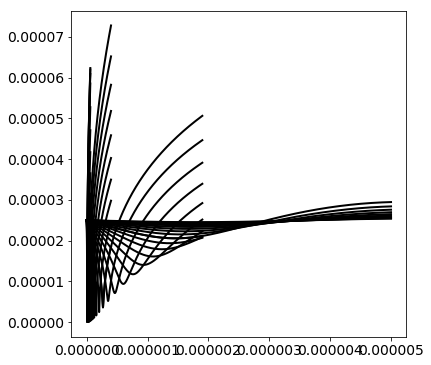

In [46]:
%matplotlib inline
from scipy.signal import argrelextrema

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 2.
plt.rcParams['lines.markersize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 18

plt.figure(figsize=(6,6))

include_shock=1.

Tc=0.9104*R0*np.sqrt(rho/pinfty)
tmax=120.*dtp
delta_t = tmax/1200000.

npt=10
R0=20e-6
pa_array=np.logspace(6,7,npt)
pa_array=np.append(pa_array,np.logspace(7,8,npt))
pa_array=np.append(pa_array,np.logspace(8,9,npt))
pa_array=np.append(pa_array,np.logspace(9,10,npt))

delta_t_array=np.ones(npt)*1e-11
delta_t_array=np.append(delta_t_array,np.ones(npt)*1.2e-12)
delta_t_array=np.append(delta_t_array,np.ones(npt)*8.3e-14)
delta_t_array=np.append(delta_t_array,np.ones(npt)*2.5e-14)

tmax_array=np.ones(npt)*500*dtp
tmax_array=np.append(tmax_array,np.ones(npt)*190.*dtp)
tmax_array=np.append(tmax_array,np.ones(npt)*40.*dtp)
tmax_array=np.append(tmax_array,np.ones(npt)*6.*dtp)

tmin=np.zeros(len(pa_array))
Rmin=np.zeros(len(pa_array))

ode15s = integrate.ode(rpg)

for i in range(len(pa_array)):
    pa=pa_array[i]
    tmax=tmax_array[i]
    delta_t=delta_t_array[i]
    num_steps = int(tmax/delta_t) + 3
    time = np.zeros((num_steps, 1))
    R2 = np.zeros((num_steps, 1))
    time[0] = 0.
    R2[0] = R0
    ode15s.set_initial_value([R2[0],include_shock*(-2.*pa/rho/c0)], 0.)
    k = 1
    while ode15s.successful() and ode15s.t < (tmax):
        ode15s.integrate(ode15s.t+delta_t)
        time[k] = ode15s.t
        R2[k] = ode15s.y[0]
        k += 1
    th=time[0:k-1]
    R2h=R2[0:k-1]
    if ode15s.successful():
        local_min=argrelextrema(R2h, np.less)
        tmin[i]=th[local_min[0][0]]-ptstart
        Rmin[i]=R2h[local_min[0][0]]    
        print i
    else: #too strong collapes, data still valid
        tmin[i]=ode15s.t-ptstart
        Rmin[i]=0.
    plt.plot(th, R2h, color='k');
    Ea=np.pi*R0**2*dtp*pa**2/(2.*rho*c0)
    Epot=4./3.*np.pi*p0*R0**3
    print Ea
    print Epot
    

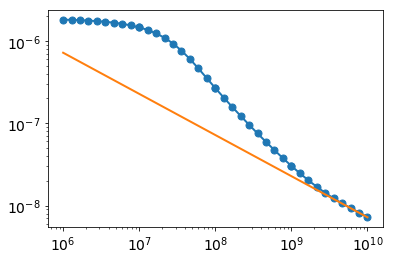

In [47]:
x=np.linspace(1e6,1e10,100)
y=0.9105*R0*np.sqrt(rho/x)
plt.loglog(pa_array,tmin,'.-')
plt.plot(x,y);

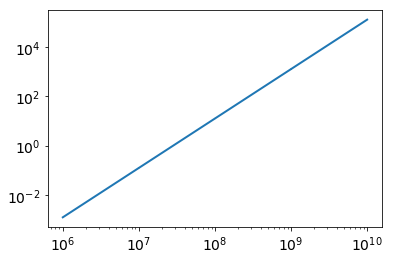

In [25]:
Eg=p0*R0**(3.*kappa)*3*kappa*np.log(R0/Rmin)
Ea=np.pi*R0**2.*dtp*pa_array**2./(2.*rho*c0)
Ep=4./3.*np.pi*p0*R0**3
plt.loglog(pa_array,Ea/(Eg+Ep))

In [1]:
plt.loglog(pa_array,Rmin, '.');

NameError: name 'plt' is not defined

In [70]:
Ea=np.pi*R0**2*dtp*pa**2/(2.*rho*c0)
Epot=4./3.*np.pi*p0*R0**3
print Ea
print Epot


4.1971845739342603e-10
3.35103216383e-09


0
4.19718457393426e-12
3.35103216383e-09


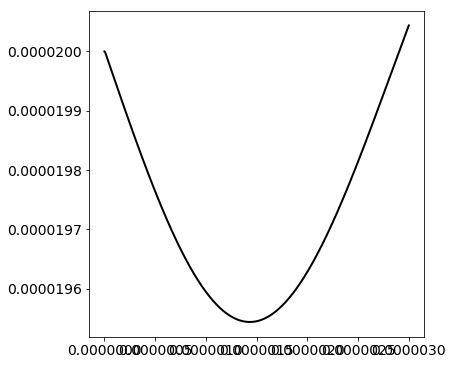

In [22]:
%matplotlib inline
from scipy.signal import argrelextrema

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 2.
plt.rcParams['lines.markersize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 18

plt.figure(figsize=(6,6))

tmax=3.*dtp
delta_t = tmax/1200000.

pa_array=np.array([1e6])
delta_t_array=np.array([1e-11])
tmax_array=np.array([300.*dtp])

tmin=np.zeros(len(pa_array))
Rmin=np.zeros(len(pa_array))

ode15s = integrate.ode(rpg)

for i in range(len(pa_array)):
    pa=pa_array[i]
    tmax=tmax_array[i]
    delta_t=delta_t_array[i]
    num_steps = int(tmax/delta_t) + 3
    time = np.zeros((num_steps, 1))
    R2 = np.zeros((num_steps, 1))
    time[0] = 0.
    R2[0] = R0
    ode15s.set_initial_value([R2[0],0.], 0.)
    k = 1
    while ode15s.successful() and ode15s.t < (tmax):
        ode15s.integrate(ode15s.t+delta_t)
        time[k] = ode15s.t
        R2[k] = ode15s.y[0]
        k += 1
    th=time[0:k-1]
    R2h=R2[0:k-1]
    if ode15s.successful():
        local_min=argrelextrema(R2h, np.less)
        tmin[i]=th[local_min[0][0]]-ptstart
        Rmin[i]=R2h[local_min[0][0]]    
        print i
    else: #too strong collapes, data still valid
        tmin[i]=ode15s.t-ptstart
        Rmin[i]=0.
    plt.plot(th, R2h, color='k');
    Ea=np.pi*R0**2*dtp*pa**2/(2.*rho*c0)
    Epot=4./3.*np.pi*p0*R0**3
    print Ea
    print Epot
    

In [48]:
import dill
dill.dump_session('R0=25um,dt10ns.db')

In [23]:
dtp

1e-07

3614460
0
1.0492961434835649e-08
3.35103216383e-09


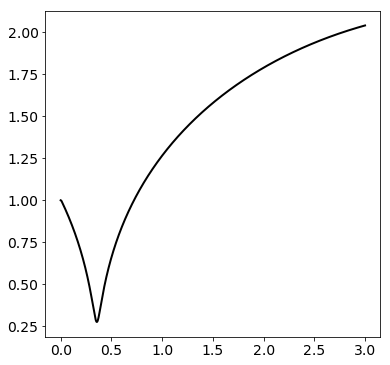

In [16]:
%matplotlib inline
from scipy.signal import argrelextrema

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 2.
plt.rcParams['lines.markersize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 18

plt.figure(figsize=(6,6))

dtp=1e-8
tmax=5.*dtp
R0=20e-6
pa_array=np.array([5e7])
delta_t_array=np.array([8.3e-13])
tmax_array=np.array([300.*dtp])

tmin=np.zeros(len(pa_array))
Rmin=np.zeros(len(pa_array))

ode15s = integrate.ode(rpg)

for i in range(len(pa_array)):
    
    pa=pa_array[i]
    tmax=tmax_array[i]
    delta_t=delta_t_array[i]
    num_steps = int(tmax/delta_t) + 3
    print num_steps
    time = np.zeros((num_steps, 1))
    R2 = np.zeros((num_steps, 1))
    time[0] = 0.
    R2[0] = R0
    ode15s.set_initial_value([R2[0],0], 0.)
    k = 1
    while ode15s.successful() and ode15s.t < (tmax):
        ode15s.integrate(ode15s.t+delta_t)
        time[k] = ode15s.t
        R2[k] = ode15s.y[0]
        k += 1
    th=time[0:k-1]
    R2h=R2[0:k-1]
    if ode15s.successful():
        local_min=argrelextrema(R2h, np.less)
        tmin[i]=th[local_min[0][0]]-ptstart
        Rmin[i]=R2h[local_min[0][0]]    
        print i
    else: #too strong collapes, data still valid
        tmin[i]=ode15s.t-ptstart
        Rmin[i]=0.
    plt.plot(th/1e-6, R2h/R0, color='k');
    Ea=np.pi*R0**2*dtp*pa**2/(2.*rho*c0)
    Epot=4./3.*np.pi*p0*R0**3
    print Ea
    print Epot
    

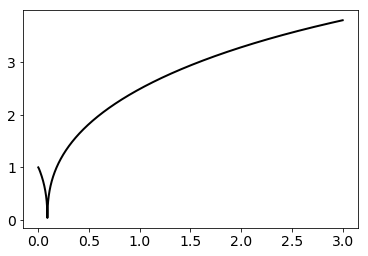

In [15]:
 plt.plot(th/1e-6, R2h/R0, color='k');

In [17]:
2e-5*rho*c0/2/pa

2.9940000000000005e-07

In [18]:
pa

50000000.0

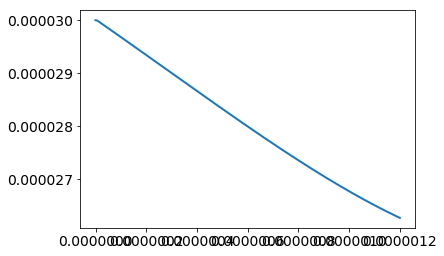

In [28]:
plt.plot(th,R2h)

In [30]:
pa/1e6

10.0

In [34]:
tmin


array([2.1962100e-06, 2.1839500e-06, 2.1681500e-06, 2.1478400e-06,
       2.1217600e-06, 2.0883400e-06, 2.0456200e-06, 1.9912200e-06,
       1.9222900e-06, 1.8356000e-06, 1.8355944e-06, 1.7277660e-06,
       1.5957492e-06, 1.4380092e-06, 1.2562332e-06, 1.0575888e-06,
       8.5594680e-07, 6.6908760e-07, 5.1147600e-07, 3.8805720e-07,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00])

In [36]:
i

20

In [37]:
range(i,len(pa_array))

[20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

In [38]:
len(pa_array)

40